# Задание по анализу данных

## Кейс
"Рекламодатель Сигма жалуется на постоянный рост CPA по своим рекламным кампаниям в последние 4 месяца (с июня по сент 2022). Ваша задача проанализировать его размещение с целью:
1. Выяснить причину растущего CPA
2. Дать рекомендации по снижению и стабилизации CPA до целевого значения (380 руб)"

### Исходные данные
Лист data

Описание столбцов таблицы на Листе data
Описание столбцов:
Client – название клиента
Device – тип устройства
Place – тип площадки (только для Type: Direct)
BannerType – тип объявления
QueryType – тип запроса (только для Type: Direct , только поиск)
TargetingType – тип таргетинга (только для Type: Direct)
Cost - расходы рекламодателя
Conversions – целевые визиты (только Директ)

### Ожидаемый результат
- Презентация в ppt с выводами и графиками
- Исходники с расчетами в свободном, но структурированном и читаемом формате (на ваше усмотрение - ссылки на xlsx-файл, data studio, bi и тд)

### Дополнительная информация
Для выполнения задания потребуются базовые знания по Яндекс.Директу.
Всю информацию можно найти в официальной справке: https://yandex.ru/support/direct/

# Исследование

## Подготовка к работе

In [1]:
# ! pip install phik

In [2]:
%%capture
# install phik (if not installed yet) для Google colab
import sys

!"{sys.executable}" -m pip install phik

In [3]:
# импортируем библиотеки
import pandas as pd
# import datetime as dt
import numpy as np
# from math import ceil
# import math as mth
import matplotlib.pyplot as plt
# import matplotlib as mpl
import seaborn as sns
# from plotly import graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots
# import scipy.stats as st
# import statsmodels.stats.api as sms
import phik
from phik import resources, report
from IPython.display import display, HTML

# для загрузки датасета из Яндекс облака:
# import requests
# from urllib.parse import urlencode

In [4]:
# снимем ограничения на вывод на экран
pd.set_option('display.max_rows', None) # Сбросим ограничения на количество выводимых рядов
# pd.set_option('display.max_columns', None) # Сбросим ограничения на число столбцов
pd.set_option('display.max_colwidth', None) # Сбросим ограничения на количество символов в записи
pd.options.display.float_format = '{:.2f}'.format # указываем количество знаков после запятой

## Загрузим датасет

https://docs.google.com/spreadsheets/d/1NyiRTHNtl5dtozlDtLhwAO5u2w1RmYah

In [5]:
! gdown 1NyiRTHNtl5dtozlDtLhwAO5u2w1RmYah

Downloading...
From: https://drive.google.com/uc?id=1NyiRTHNtl5dtozlDtLhwAO5u2w1RmYah
To: /content/task.xlsx
100% 593k/593k [00:00<00:00, 140MB/s]


In [6]:
df = pd.read_excel('/content/task.xlsx', sheet_name='data')

## Посмотрим на данные с разных сторон

In [7]:
df.head()

,Client,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost,Conversions
0,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Phrase,0,0,0.00,0
1,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Retargeting,5949,41,1666.84,0
2,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,cpc_video,none,Retargeting,191,6,40.64,0
3,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,227,1,45.75,0
4,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,18,0,0.00,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10478 entries, 0 to 10477
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Client                   10478 non-null  object        
 1   Month                    10478 non-null  datetime64[ns]
 2   Category                 10478 non-null  object        
 3   Device                   10478 non-null  object        
 4   Place                    10478 non-null  object        
 5   BannerType               10478 non-null  object        
 6   QueryType (search only)  10478 non-null  object        
 7   TargetingType            10478 non-null  object        
 8   Shows                    10478 non-null  int64         
 9   Clicks                   10478 non-null  int64         
 10  Cost                     10478 non-null  float64       
 11  Conversions              10478 non-null  int64         
dtypes: datetime64[ns](1), float64(1)

In [9]:
df = df.rename(columns={'QueryType (search only)': 'QueryType'})

In [10]:
# Проверим наличие дублей:
print('Полных дублей:', df.duplicated().sum())

Полных дублей: 0


In [11]:
# а так же наличие неполных дублей:
print('Неполных дублей:', df.duplicated(keep=False, subset=['Client', 'Month', 'Category', 'Device', 'Place', 'BannerType', 'QueryType', 'TargetingType']).sum())

Неполных дублей: 18


In [12]:
# выведем неполные дубли (так как их 18 - ограничим вывод 20 строками на случай изменения в будующем исходного датасета):
df[df.duplicated(keep=False, subset=['Client', 'Month', 'Category', 'Device', 'Place', 'BannerType', 'QueryType', 'TargetingType'])].head(20)

,Client,Month,Category,Device,Place,BannerType,QueryType,TargetingType,Shows,Clicks,Cost,Conversions
7484,Псилон,2021-05-01,ИНВЕСТИЦИИ,Mobile,Networks,image_ad,none,Retargeting,8612,21,2246.55,0
7486,Псилон,2021-05-01,ИНВЕСТИЦИИ,Mobile,Networks,image_ad,none,Retargeting,0,0,0.00,0
7651,Сигма,2021-11-01,ИНВЕСТИЦИИ,Desktop,Networks,image_ad,none,Phrase,22,0,0.00,0
7652,Сигма,2021-11-01,ИНВЕСТИЦИИ,Mobile,Networks,image_ad,none,Phrase,321,3,19.45,0
7653,Сигма,2021-11-01,ИНВЕСТИЦИИ,Desktop,Networks,image_ad,none,Phrase,9071,40,304.62,0
7655,Сигма,2021-11-01,ИНВЕСТИЦИИ,Mobile,Networks,image_ad,none,Phrase,3276,68,410.49,0
7686,Сигма,2021-12-01,ИНВЕСТИЦИИ,Desktop,Networks,image_ad,none,Phrase,75,0,0.00,0
7687,Сигма,2021-12-01,ИНВЕСТИЦИИ,Mobile,Networks,image_ad,none,Phrase,1290,20,103.70,0
7688,Псилон,2021-12-01,ИНВЕСТИЦИИ,Desktop,Networks,image_ad,none,Phrase,4337,11,90.12,0
7689,Псилон,2021-12-01,ИНВЕСТИЦИИ,Desktop,Networks,image_ad,none,Retargeting,1249,2,29.99,0


Это всё 2021 год, один дубль в мае, два - в ноябре и 6 - в декабре
Во время группировок эти дубли сложатся, два вопроса:
1. Корректно ли сформирован для нас исходный датасет?
2. за что мы платим? За показ, клик или целевой визит: есть расходы рекламодателя в строках где нет целевых визитов

In [13]:
print('Строк в которых есть клики, но нет показов:', df.loc[(df['Shows'] == 0) & (df['Clicks'] != 0)]['Clicks'].count())

Строк в которых есть клики, но нет показов: 0


In [14]:
print('Строк в которых есть целевые действия, но нет кликов:', df.loc[(df['Clicks'] == 0) & (df['Conversions'] != 0)]['Conversions'].count())

Строк в которых есть целевые действия, но нет кликов: 323


In [15]:
print('Строк в которых есть целевые действия, но нет показов:', df.loc[(df['Shows'] == 0) & (df['Conversions'] != 0)]['Conversions'].count())

Строк в которых есть целевые действия, но нет показов: 305


In [16]:
print('Строк в которых есть затраты, но нет кликов:', df.loc[(df['Clicks'] == 0) & (df['Cost'] != 0)]['Conversions'].count())

Строк в которых есть затраты, но нет кликов: 0


In [17]:
print('Строк в которых есть клики, но нет затрат:', df.loc[(df['Clicks'] != 0) & (df['Cost'] == 0)]['Conversions'].count())

Строк в которых есть клики, но нет затрат: 0


In [18]:
print('Строк в которых есть затраты, но нет целевых действий:', df.loc[(df['Conversions'] == 0) & (df['Cost'] != 0)]['Conversions'].count())

Строк в которых есть затраты, но нет целевых действий: 1696


In [19]:
print('В датасете данные за период с', df['Month'].min().date(), 'по', df['Month'].max().date())

В датасете данные за период с 2021-04-01 по 2022-09-01


### Промежуточные выводы
В датасете в 323 строках есть целевые действия, но нет кликов и в 305 строках есть целевые действия, но нет показов - сие непонятно.

Расходы есть во всех строках с кликами и клики есть во всех строках с расходами, что является еще одним подтверждением того, что рекламодатели оплачивали клики


## Исследуем типы данных столбцов, их содержимое, в том числе на соответствие рациональному виду, при необходимости изменим тип данных столбцов

In [20]:
# сформируем кадр данных, показывающий количество уникальных значений в столбцах

# from_records: создает объект DataFrame из структурированного массива
pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

,Column_Name,Num_Unique
3,Device,2
4,Place,2
7,TargetingType,3
6,QueryType,4
2,Category,7
5,BannerType,7
0,Client,10
1,Month,18
11,Conversions,1680
9,Clicks,4636


In [21]:
# Далее будем рассматривать данные по характеристикам у которых до 12 уникальных значений в столбцах
columns_categ = ['Client', 'Category', 'Device', 'Place', 'BannerType', 'QueryType', 'TargetingType']
for i in columns_categ:
  print(df[i].value_counts(), '\n')

Псилон    2186
Сигма     1560
Гамма     1446
Зета      1371
Бета      1141
Омега      927
Альфа      894
Дельта     373
Лямбда     350
Мета       230
Name: Client, dtype: int64 

ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ      2595
РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ    1885
КРЕДИТНЫЕ КАРТЫ                   1805
ДЕБЕТОВЫЕ КАРТЫ                   1358
ВКЛАДЫ                            1223
ИПОТЕЧНОЕ КРЕДИТОВАНИЕ            1174
ИНВЕСТИЦИИ                         438
Name: Category, dtype: int64 

Desktop    5362
Mobile     5116
Name: Device, dtype: int64 

Search      6070
Networks    4408
Name: Place, dtype: int64 

text           6884
mcbanner       1407
image_ad       1394
cpm_banner      726
cpc_video        60
performance       6
dynamic           1
Name: BannerType, dtype: int64 

none          4408
Other         2063
Competitor    2008
Brand         1999
Name: QueryType, dtype: int64 

Phrase           7960
Retargeting      2214
Autotargeting     304
Name: TargetingType, dtype: int64 



In [22]:
for col in columns_categ:
    df[col] = df[col].astype('category')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10478 entries, 0 to 10477
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Client         10478 non-null  category      
 1   Month          10478 non-null  datetime64[ns]
 2   Category       10478 non-null  category      
 3   Device         10478 non-null  category      
 4   Place          10478 non-null  category      
 5   BannerType     10478 non-null  category      
 6   QueryType      10478 non-null  category      
 7   TargetingType  10478 non-null  category      
 8   Shows          10478 non-null  int64         
 9   Clicks         10478 non-null  int64         
 10  Cost           10478 non-null  float64       
 11  Conversions    10478 non-null  int64         
dtypes: category(7), datetime64[ns](1), float64(1), int64(3)
memory usage: 482.7 KB


In [24]:
columns_num = ['Shows', 'Clicks', 'Cost', 'Conversions']
df[columns_num].describe()

,Shows,Clicks,Cost,Conversions
count,10478.00,10478.00,10478.00,10478.00
mean,1715048.61,9769.44,359829.32,507.98
std,15449238.73,44548.19,1211802.19,2086.40
min,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00
50%,11811.50,280.50,13046.77,2.00
75%,132642.50,5130.25,211153.43,94.00
max,583150600.00,2237376.00,39766179.12,47259.00


### Рассчитаем CPM, CPC, CPA

In [25]:
df['CPM'] = np.nan
df['CPC'] = np.nan
df['CPA'] = np.nan

In [26]:
# Стоимость показа 
# Значения в строках в которых нет показов, но есть расходы расчитывать не будем

df.loc[(df['Shows'] == 0) & (df['Cost'] == 0), 'CPM'] = 0
df.loc[(df['Shows'] != 0),                     'CPM'] = df['Cost'] / df['Shows']

In [27]:
# Стоимость клика
# Значения в строках в которых нет кликов, но есть расходы расчитывать не будем

df.loc[(df['Clicks'] == 0) & (df['Cost'] == 0), 'CPC'] = 0
df.loc[(df['Clicks'] != 0),                     'CPC'] = df['Cost'] / df['Clicks']

In [28]:
# Стоимость целевого действия
# Значения в строках в которых нет целевых переходов, но есть расходы расчитывать не будем

df.loc[(df['Conversions'] != 0),                     'CPA'] = df['Cost'] / df['Conversions']
df.loc[(df['Conversions'] == 0) & (df['Cost'] == 0), 'CPA'] = 0


In [29]:
columns_cp = ['CPM', 'CPC', 'CPA']
df[columns_cp].describe()

,CPM,CPC,CPA
count,10478.00,10478.00,8782.00
mean,3.32,61.43,6271.70
std,6.58,129.50,45117.80
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.16,19.71,398.40
75%,4.26,62.72,1738.82
max,155.63,1981.23,2227386.43


Видим, что средние в разы больше медиан - есть выбросы, посмотрим далее

### Исследуем корреляцию расходов с показами, кликами и целевыми визитами

In [30]:
# В список colomns_review сохраним те характеристики, с которыми будем исследовать корреляцию расходов рекламодателей:
colomns_review = ['Shows', 'Clicks', 'Cost',	'Conversions']
# зададим размеры выводимых графиков на этом этапе, а так же зададим, график будет одинок 
height = 4
width = 5

num_cols = 1
num_rows = 1

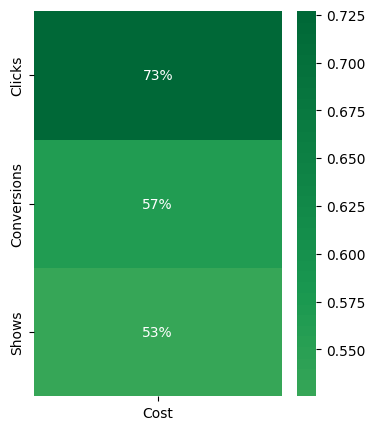

In [31]:
# Сначала проведем исследование с применением коэффициента Пирсона:

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize=(height, width)) 

sns.heatmap(df[colomns_review].corr().loc[:,['Cost']].drop('Cost').sort_values(by='Cost', ascending=False),\
            annot=True,\
            fmt=".0%",\
            cmap='RdYlGn',\
            center=0); 
plt.show()

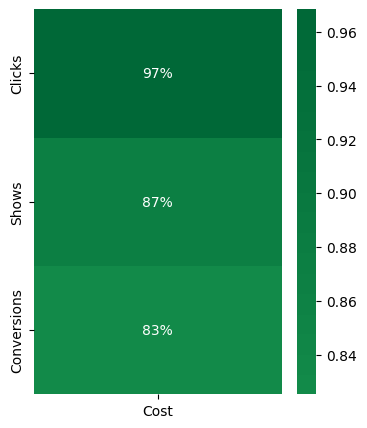

In [32]:
# Теперь проведем исследование с применением коэффициента Спирмена:
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize=(height, width)) 

sns.heatmap(df[colomns_review].corr(method='spearman').loc[:,['Cost']].drop('Cost').sort_values(by='Cost', ascending=False),\
            annot=True,\
            fmt=".0%",\
            cmap='RdYlGn',\
            center=0);
plt.show()

interval columns not set, guessing: ['Shows', 'Clicks', 'Cost', 'Conversions']


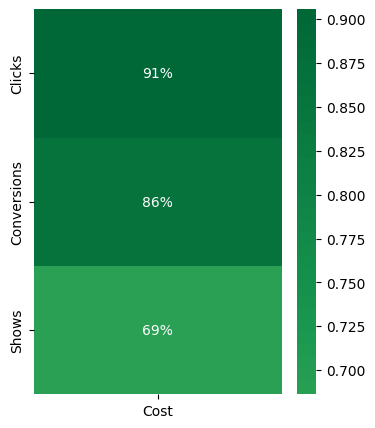

In [33]:
# Теперь проведем исследование с применением коэффициента Phi_K:
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize=(height, width)) 

sns.heatmap(df[colomns_review].phik_matrix().loc[:,['Cost']].drop('Cost').sort_values(by='Cost', ascending=False),\
            annot=True,\
            fmt=".0%",\
            cmap='RdYlGn',\
            center=0); 
plt.show()

#### Промежуточные выводы
По всем трем коэффициентам затраты рекламодателей наибольшим образом коррелируются с кликами, делаем окончательный вывод, что рекламодетель платит за клики, но отслеживает (в частности наш рекламоатель Сигма) в том числе целевые переходы.

## Выделим клиентов Сигмы в отдельный датасет и рассмотрим их подробнее

In [34]:
df_sigma = df[df['Client'] == 'Сигма']

In [35]:
df_sigma.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 8 to 10446
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Client         1560 non-null   category      
 1   Month          1560 non-null   datetime64[ns]
 2   Category       1560 non-null   category      
 3   Device         1560 non-null   category      
 4   Place          1560 non-null   category      
 5   BannerType     1560 non-null   category      
 6   QueryType      1560 non-null   category      
 7   TargetingType  1560 non-null   category      
 8   Shows          1560 non-null   int64         
 9   Clicks         1560 non-null   int64         
 10  Cost           1560 non-null   float64       
 11  Conversions    1560 non-null   int64         
 12  CPM            1560 non-null   float64       
 13  CPC            1560 non-null   float64       
 14  CPA            1333 non-null   float64       
dtypes: category(7), date

In [36]:
# Далее будем рассматривать данные по характеристикам у которых до 12 уникальных значений в столбцах
columns_categ = ['Category', 'Device', 'Place', 'BannerType', 'QueryType', 'TargetingType']
for i in columns_categ:
  print(df_sigma[i].value_counts(), '\n')

РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ    307
ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ      278
КРЕДИТНЫЕ КАРТЫ                   238
ИПОТЕЧНОЕ КРЕДИТОВАНИЕ            236
ДЕБЕТОВЫЕ КАРТЫ                   208
ВКЛАДЫ                            207
ИНВЕСТИЦИИ                         86
Name: Category, dtype: int64 

Desktop    788
Mobile     772
Name: Device, dtype: int64 

Search      803
Networks    757
Name: Place, dtype: int64 

text           1201
image_ad        200
cpm_banner       94
mcbanner         58
cpc_video         7
dynamic           0
performance       0
Name: BannerType, dtype: int64 

none          757
Other         273
Competitor    268
Brand         262
Name: QueryType, dtype: int64 

Phrase           1114
Retargeting       370
Autotargeting      76
Name: TargetingType, dtype: int64 



In [37]:
df_sigma[columns_num + columns_cp].describe()

,Shows,Clicks,Cost,Conversions,CPM,CPC,CPA
count,1560.00,1560.00,1560.00,1560.00,1560.00,1560.00,1333.00
mean,2132104.57,12022.68,247485.13,579.58,2.59,48.54,3347.46
std,9812200.32,32103.49,497734.85,1668.60,5.28,124.77,18679.88
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,95.00,1.00,18.02,0.00,0.01,3.81,0.00
50%,28653.00,955.50,24481.42,14.00,0.12,14.20,266.12
75%,211056.00,9311.75,272263.94,295.50,3.13,35.38,1433.27
max,215900882.00,567033.00,5843984.93,17902.00,53.59,1819.41,384782.04


In [38]:
df_sigma.head()

,Client,Month,Category,Device,Place,BannerType,QueryType,TargetingType,Shows,Clicks,Cost,Conversions,CPM,CPC,CPA
8,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Phrase,531,4,99.49,0,0.19,24.87,NaN
9,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,215,2,52.66,0,0.24,26.33,NaN
55,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Phrase,5053827,2531,74531.40,0,0.01,29.45,NaN
56,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Retargeting,45630,50,1536.41,0,0.03,30.73,NaN
57,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Search,text,Brand,Phrase,6933,1036,27636.63,0,3.99,26.68,NaN


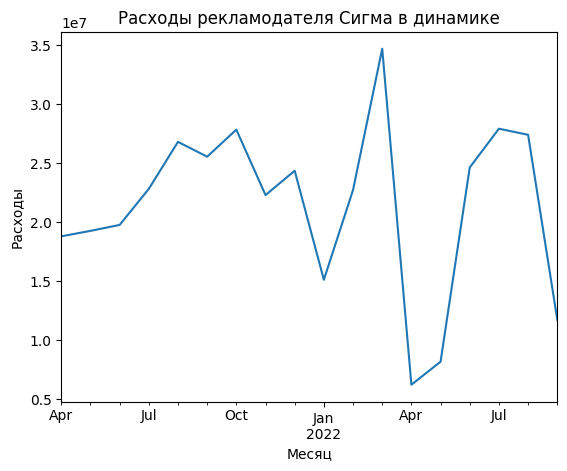

In [39]:
df_sigma_tmp = df_sigma.groupby(by=['Month']).agg(Cost=('Cost', 'sum'), Conversions=('Conversions', 'sum'), Clicks=('Clicks', 'sum'), Shows=('Shows', 'sum'))

df_sigma_tmp['Cost'].plot(title='Расходы рекламодателя Сигма в динамике', xlabel='Месяц', ylabel='Расходы');

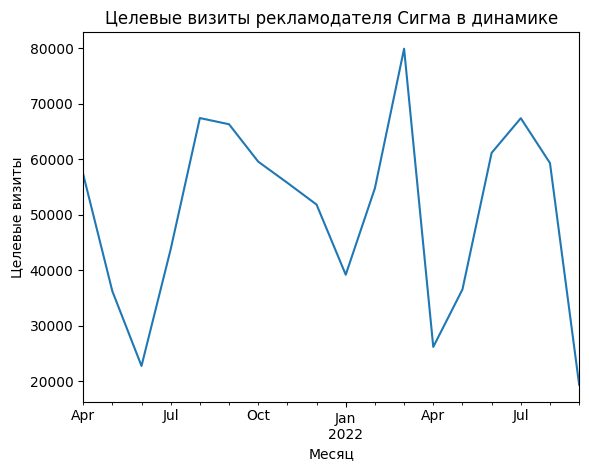

In [40]:
df_sigma_tmp['Conversions'].plot(title='Целевые визиты рекламодателя Сигма в динамике', xlabel='Месяц', ylabel='Целевые визиты');

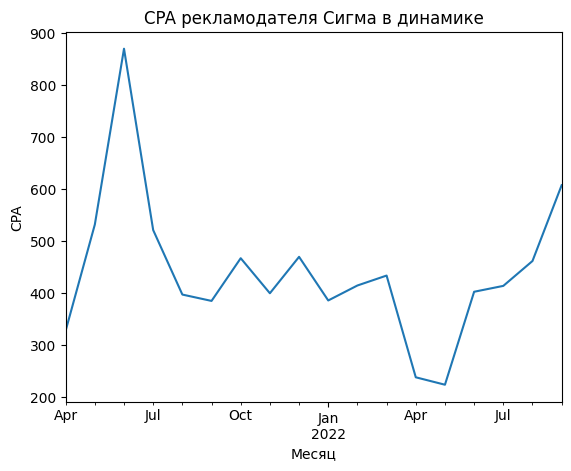

In [41]:
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] != 0),                               'CPA'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Conversions']
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPA'] = 0

df_sigma_tmp['CPA'].plot(title='CPA рекламодателя Сигма в динамике', xlabel='Месяц', ylabel='CPA');

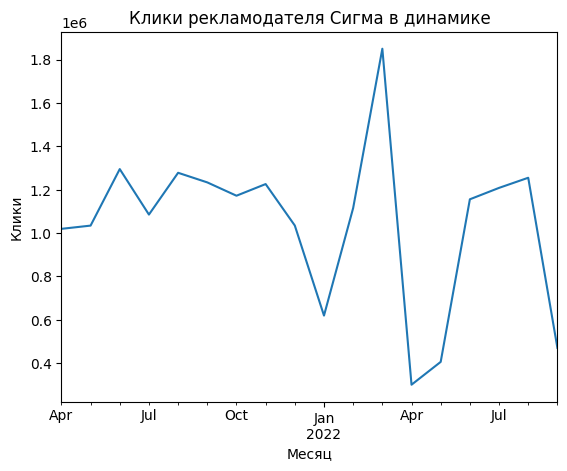

In [42]:
df_sigma_tmp['Clicks'].plot(title='Клики рекламодателя Сигма в динамике', xlabel='Месяц', ylabel='Клики');

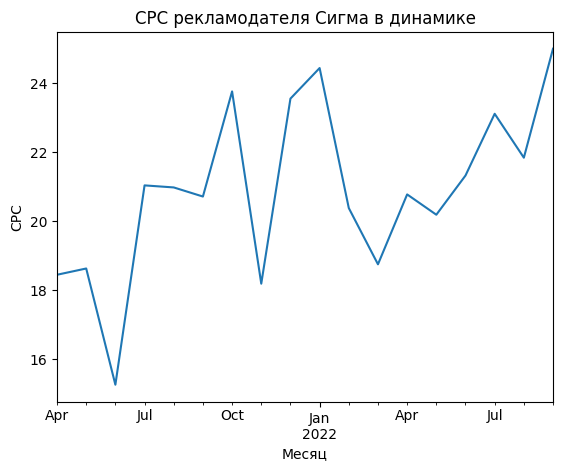

In [43]:
df_sigma_tmp.loc[(df_sigma_tmp['Clicks'] != 0),                               'CPC'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Clicks']
df_sigma_tmp.loc[(df_sigma_tmp['Clicks'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPC'] = 0
df_sigma_tmp['CPC'].plot(title='CPC рекламодателя Сигма в динамике', xlabel='Месяц', ylabel='CPC');

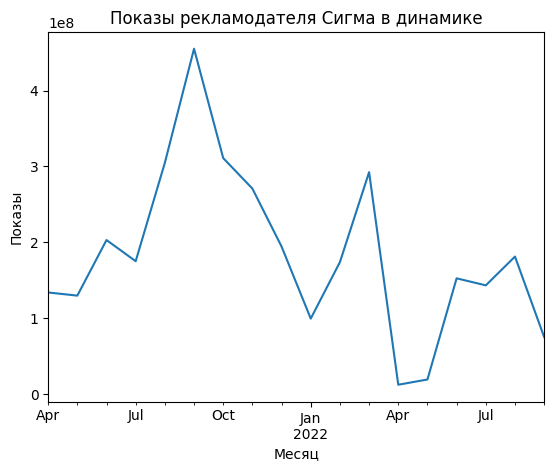

In [44]:
df_sigma_tmp['Shows'].plot(title='Показы рекламодателя Сигма в динамике', xlabel='Месяц', ylabel='Показы');

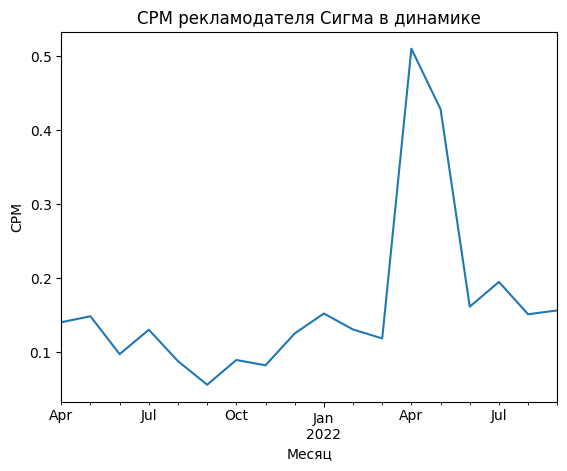

In [45]:
# Здесь и далее будем считать сумму за один показ, а не за 1000, как предполагает параметр CPM чтобы было удобнее сравнивать и не держать это всё время в голове
df_sigma_tmp.loc[(df_sigma_tmp['Shows'] != 0),                               'CPM'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Shows']
df_sigma_tmp.loc[(df_sigma_tmp['Shows'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPM'] = 0
df_sigma_tmp['CPM'].plot(title='CPM рекламодателя Сигма в динамике', xlabel='Месяц', ylabel='CPM');

### Промежуточные выводы
Расходы нашего рекламодателя в январе 2022 г. упали относительно декабря 2021г. в феврале вернулись на уровень декабря 2021 г. После того, как 03 марта 2022 Google заявила, что приостановила всю рекламу в России затраты нашего рекламодателя на рекламу в Яндексе резко увеличились, пропорционально (и это не может не радовать) возрасло кол-во целевых визитов (соответственно CPA выросла, но незначительно).
В апреле 2022г. наш рекламодатель кардинально снижает расходы на рекламу, кол-во целевых действий падает, CPA так же значительно снижается (в полтора - два раза)
В мае ЦБ РФ снижает ставку рефинансирования до 14, потом 11 %, в июне расходы нашего рекламодетеля (а так же ко-ло целевых действий и CPA) возвращаются на уровень декабря 2021, февраля 2022гг.
С июля расходы, целевые действия немного снижаются в августе и сильно сокращаются в сентябре 2022 г. (в районы мартовских значений).

## Посмотрим затраты на рекламу и получаемый результат в разрезе разных характеристик в динамике:

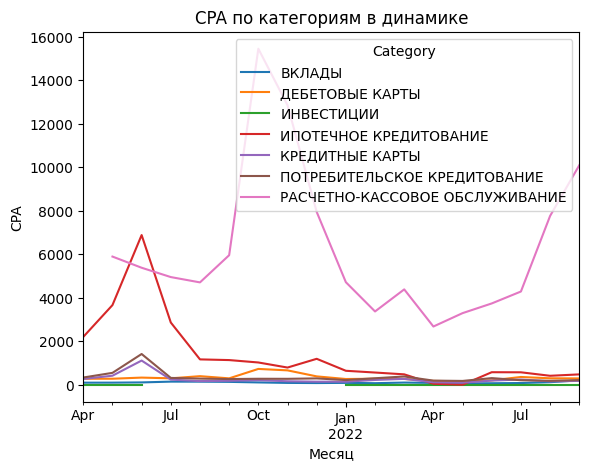

In [46]:
# посмотрим в динамике CPA по категориям:

df_sigma_tmp = df_sigma.groupby(by=['Month',	'Category']).agg(Cost=('Cost', 'sum'), Conversions=('Conversions', 'sum'))
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] != 0),                               'CPA'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Conversions']
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPA'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='Category', values='CPA', aggfunc='mean')\
    .plot(title='CPA по категориям в динамике', xlabel='Месяц', ylabel='CPA');

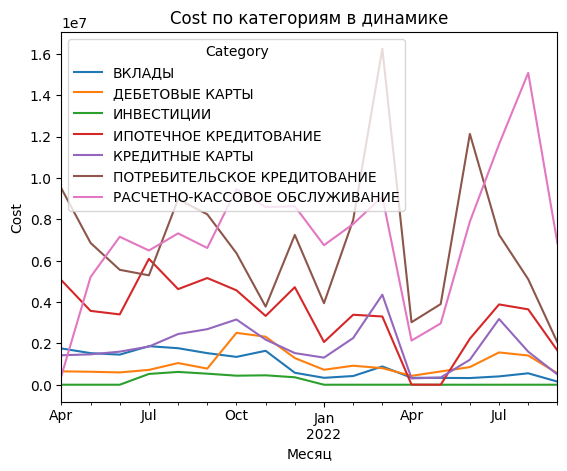

In [47]:
df_sigma_tmp.pivot_table(index='Month', columns='Category', values='Cost', aggfunc='mean')\
    .plot(title='Cost по категориям в динамике', xlabel='Месяц', ylabel='Cost');

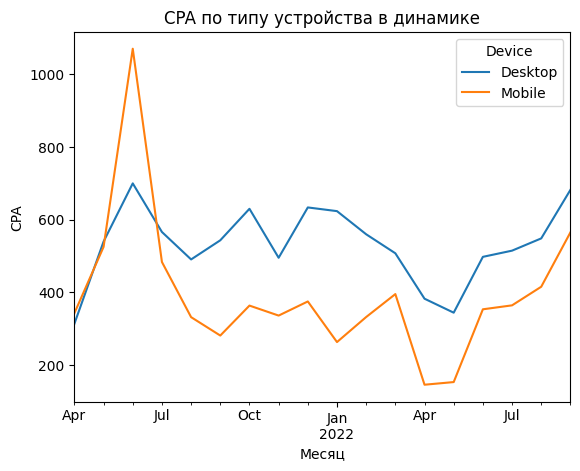

In [48]:
# посмотрим в динамике CPA по типу устройства:

df_sigma_tmp = df_sigma.groupby(by=['Month',	'Device']).agg(Cost=('Cost', 'sum'), Conversions=('Conversions', 'sum'))
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] != 0),                               'CPA'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Conversions']
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPA'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='Device', values='CPA', aggfunc='mean')\
    .plot(title='CPA по типу устройства в динамике', xlabel='Месяц', ylabel='CPA');

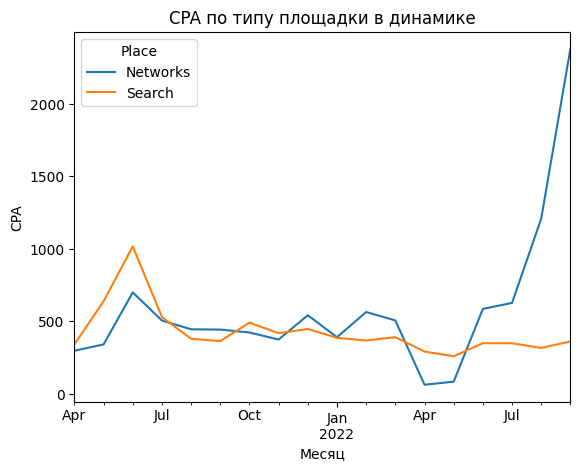

In [49]:
# посмотрим в динамике CPA по типу площадки:

df_sigma_tmp = df_sigma.groupby(by=['Month',	'Place']).agg(Cost=('Cost', 'sum'), Conversions=('Conversions', 'sum'), Clicks=('Clicks', 'sum'))
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] != 0),                               'CPA'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Conversions']
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPA'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='Place', values='CPA', aggfunc='mean')\
    .plot(title='CPA по типу площадки в динамике', xlabel='Месяц', ylabel='CPA');

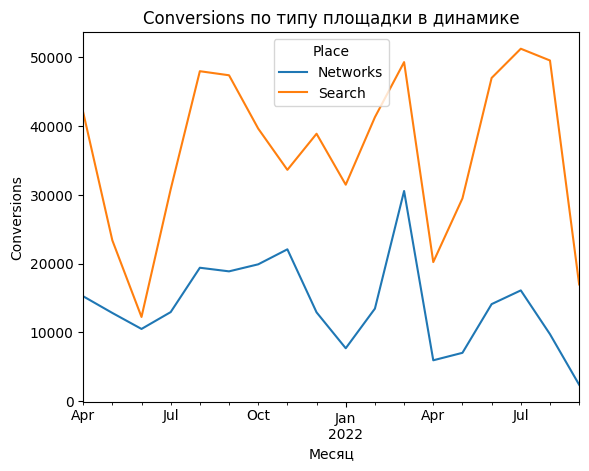

In [50]:
df_sigma_tmp.pivot_table(index='Month', columns='Place', values='Conversions', aggfunc='mean')\
    .plot(title='Conversions по типу площадки в динамике', xlabel='Месяц', ylabel='Conversions');

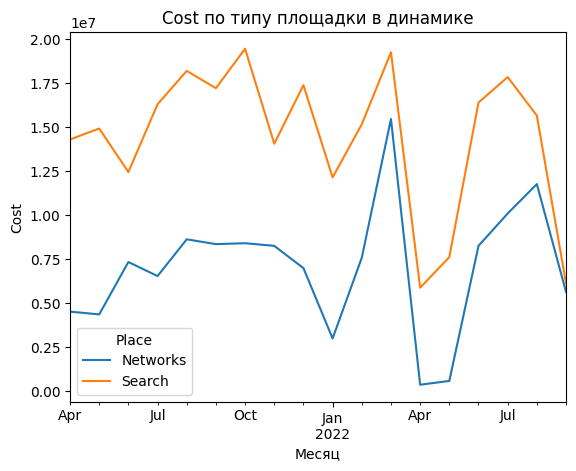

In [51]:
df_sigma_tmp.pivot_table(index='Month', columns='Place', values='Cost', aggfunc='mean')\
    .plot(title='Cost по типу площадки в динамике', xlabel='Месяц', ylabel='Cost');

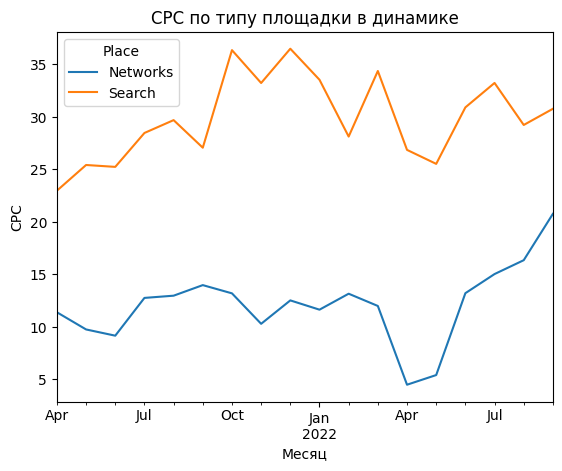

In [52]:
df_sigma_tmp.loc[(df_sigma_tmp['Clicks'] != 0),                               'CPC'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Clicks']
df_sigma_tmp.loc[(df_sigma_tmp['Clicks'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPC'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='Place', values='CPC', aggfunc='mean')\
    .plot(title='CPC по типу площадки в динамике', xlabel='Месяц', ylabel='CPC');

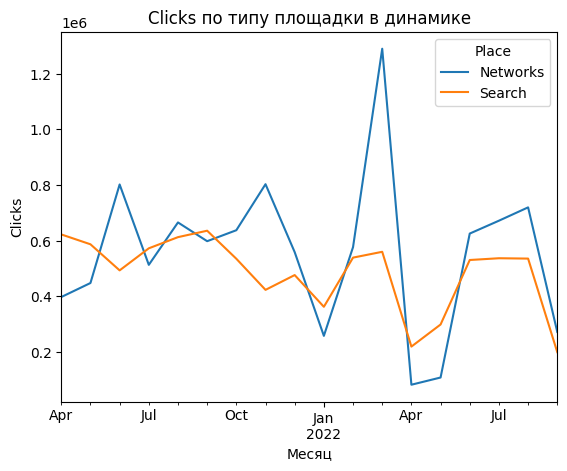

In [53]:
df_sigma_tmp.pivot_table(index='Month', columns='Place', values='Clicks', aggfunc='mean')\
    .plot(title='Clicks по типу площадки в динамике', xlabel='Месяц', ylabel='Clicks');

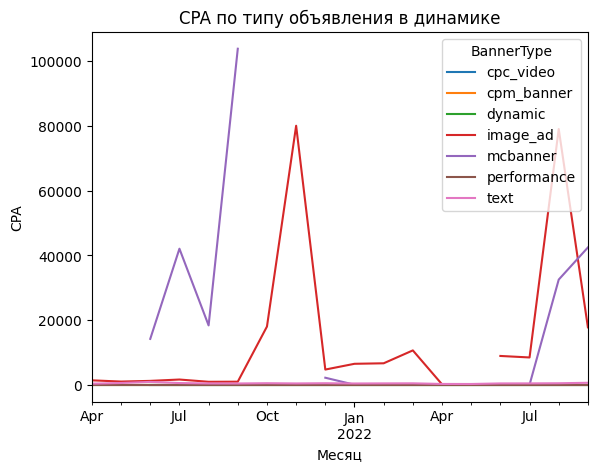

In [54]:
# посмотрим в динамике CPA по типу объявления:

df_sigma_tmp = df_sigma.groupby(by=['Month',	'BannerType']).agg(Cost=('Cost', 'sum'), Conversions=('Conversions', 'sum'))
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] != 0),                               'CPA'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Conversions']
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPA'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='BannerType', values='CPA', aggfunc='mean')\
    .plot(title='CPA по типу объявления в динамике', xlabel='Месяц', ylabel='CPA');

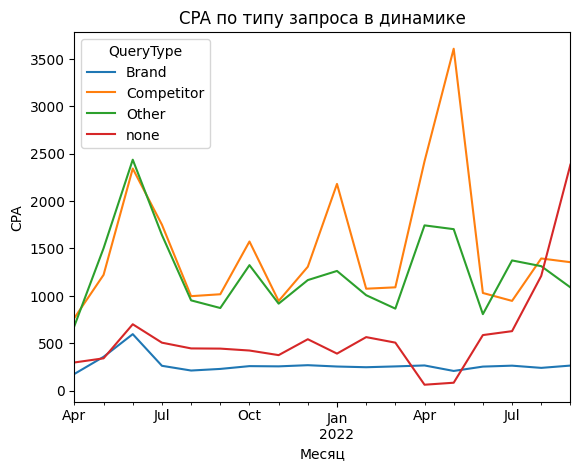

In [55]:
# посмотрим в динамике CPA по типу запроса:

df_sigma_tmp = df_sigma.groupby(by=['Month',	'QueryType']).agg(Cost=('Cost', 'sum'), Conversions=('Conversions', 'sum'), Clicks=('Clicks', 'sum'))
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] != 0),                               'CPA'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Conversions']
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPA'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='QueryType', values='CPA', aggfunc='mean')\
    .plot(title='CPA по типу запроса в динамике', xlabel='Месяц', ylabel='CPA');

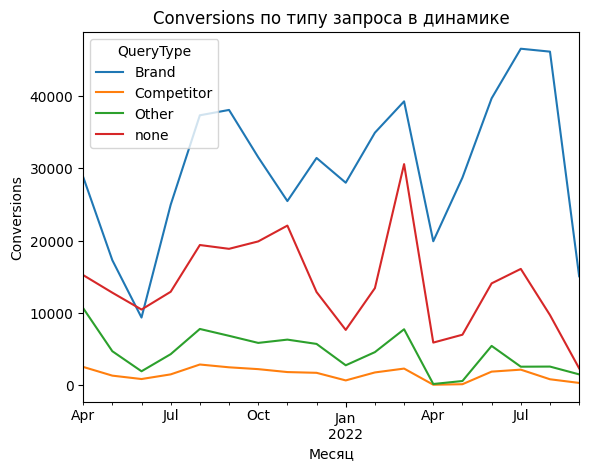

In [56]:
df_sigma_tmp.pivot_table(index='Month', columns='QueryType', values='Conversions', aggfunc='mean')\
    .plot(title='Conversions по типу запроса в динамике', xlabel='Месяц', ylabel='Conversions');

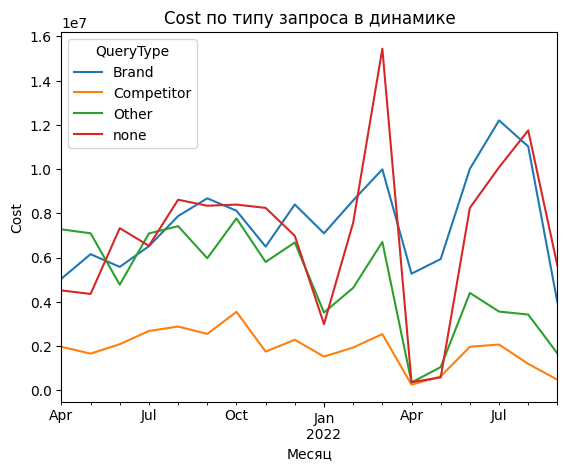

In [57]:
df_sigma_tmp.pivot_table(index='Month', columns='QueryType', values='Cost', aggfunc='mean')\
    .plot(title='Cost по типу запроса в динамике', xlabel='Месяц', ylabel='Cost');

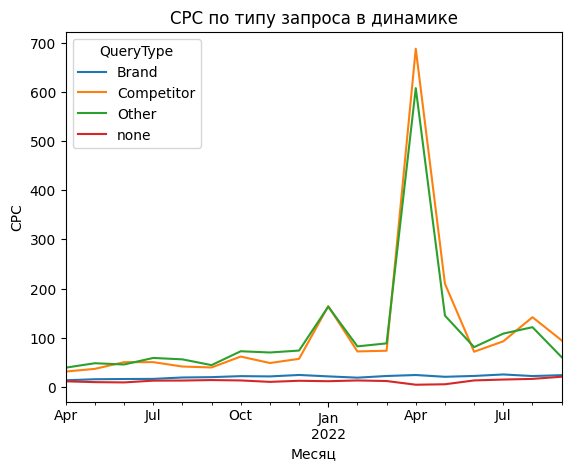

In [58]:
df_sigma_tmp.loc[(df_sigma_tmp['Clicks'] != 0),                               'CPC'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Clicks']
df_sigma_tmp.loc[(df_sigma_tmp['Clicks'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPC'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='QueryType', values='CPC', aggfunc='mean')\
    .plot(title='CPC по типу запроса в динамике', xlabel='Месяц', ylabel='CPC');

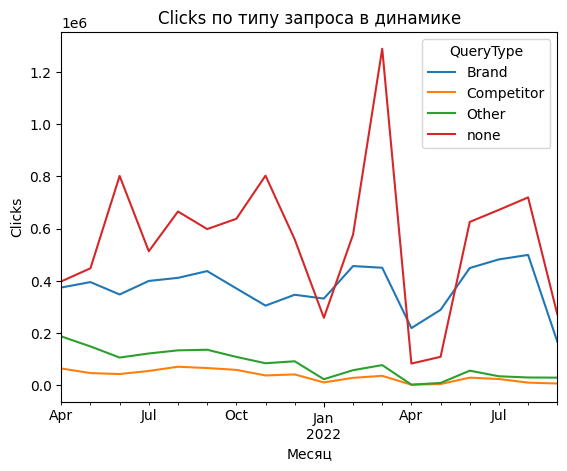

In [59]:
df_sigma_tmp.pivot_table(index='Month', columns='QueryType', values='Clicks', aggfunc='mean')\
    .plot(title='Clicks по типу запроса в динамике', xlabel='Месяц', ylabel='Clicks');

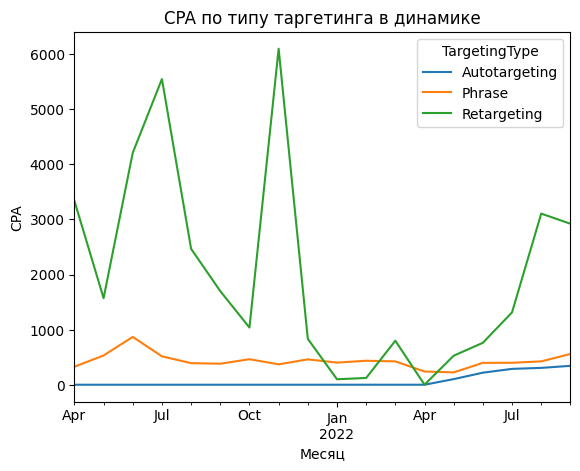

In [60]:
# посмотрим в динамике CPA по типу таргетинга:

df_sigma_tmp = df_sigma.groupby(by=['Month',	'TargetingType']).agg(Cost=('Cost', 'sum'), Conversions=('Conversions', 'sum'), Clicks=('Clicks', 'sum'))
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] != 0),                               'CPA'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Conversions']
df_sigma_tmp.loc[(df_sigma_tmp['Conversions'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPA'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='TargetingType', values='CPA', aggfunc='mean')\
    .plot(title='CPA по типу таргетинга в динамике', xlabel='Месяц', ylabel='CPA');

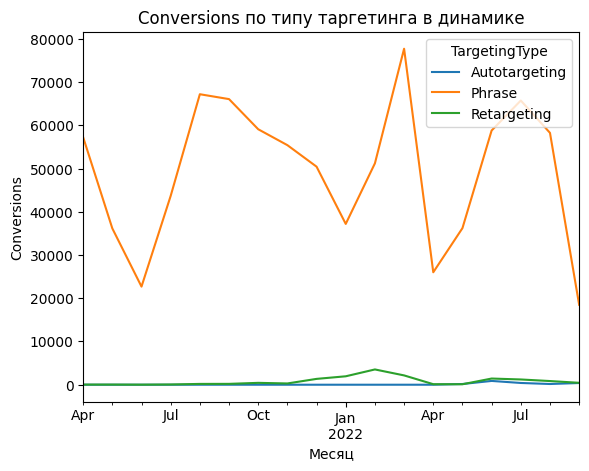

In [61]:
df_sigma_tmp.pivot_table(index='Month', columns='TargetingType', values='Conversions', aggfunc='mean')\
    .plot(title='Conversions по типу таргетинга в динамике', xlabel='Месяц', ylabel='Conversions');

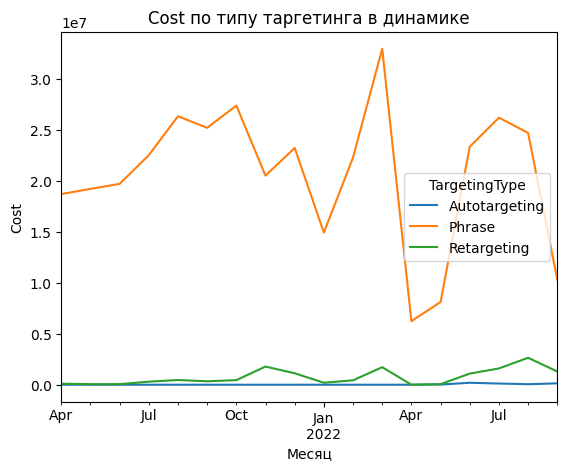

In [62]:
df_sigma_tmp.pivot_table(index='Month', columns='TargetingType', values='Cost', aggfunc='mean')\
    .plot(title='Cost по типу таргетинга в динамике', xlabel='Месяц', ylabel='Cost');

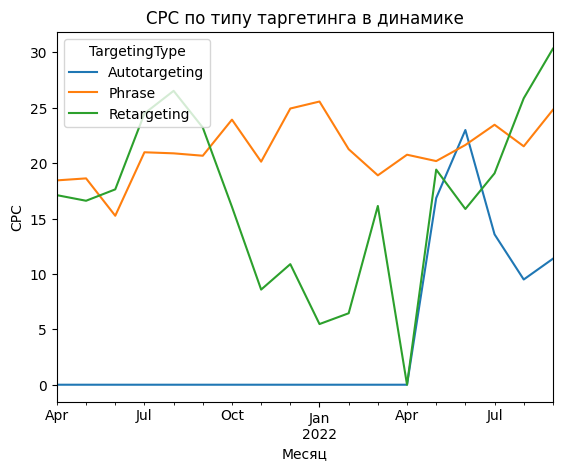

In [63]:
df_sigma_tmp.loc[(df_sigma_tmp['Clicks'] != 0),                               'CPC'] = df_sigma_tmp['Cost'] / df_sigma_tmp['Clicks']
df_sigma_tmp.loc[(df_sigma_tmp['Clicks'] == 0) & (df_sigma_tmp['Cost'] == 0), 'CPC'] = 0

df_sigma_tmp.pivot_table(index='Month', columns='TargetingType', values='CPC', aggfunc='mean')\
    .plot(title='CPC по типу таргетинга в динамике', xlabel='Месяц', ylabel='CPC');

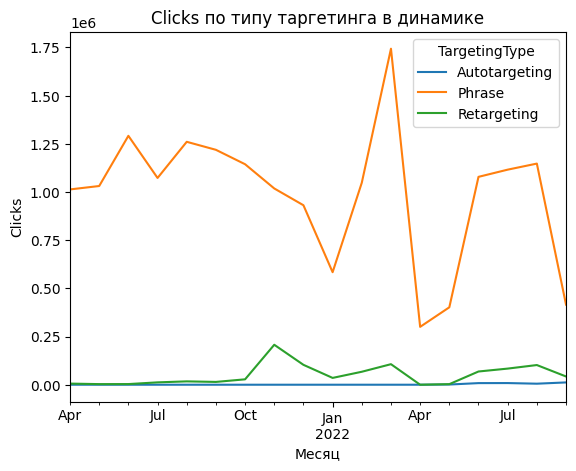

In [64]:
df_sigma_tmp.pivot_table(index='Month', columns='TargetingType', values='Clicks', aggfunc='mean')\
    .plot(title='Clicks по типу таргетинга в динамике', xlabel='Месяц', ylabel='Clicks');

Выделим из датасета датасет с июня 2022 года

In [65]:
df_sigma_view = df_sigma[df_sigma['Month'] >= '2022-06-01']
print('Минимальная дата df_sigma_view', df_sigma_view['Month'].min(), ', максимальная дата df_sigma_view:', df_sigma_view['Month'].max())

Минимальная дата df_sigma_view 2022-06-01 00:00:00 , максимальная дата df_sigma_view: 2022-09-01 00:00:00


In [66]:
df_sigma_view.head()

,Client,Month,Category,Device,Place,BannerType,QueryType,TargetingType,Shows,Clicks,Cost,Conversions,CPM,CPC,CPA
1414,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Phrase,691662,800,27195.09,3,0.04,33.99,9065.03
1415,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,62231,64,2596.61,0,0.04,40.57,NaN
1416,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Phrase,781123,4445,34841.90,2,0.04,7.84,17420.95
1417,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,59842,450,6232.86,3,0.10,13.85,2077.62
1463,Сигма,2022-06-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Phrase,33142457,32221,905710.78,99,0.03,28.11,9148.59


In [67]:
df_sigma_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 1414 to 10446
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Client         366 non-null    category      
 1   Month          366 non-null    datetime64[ns]
 2   Category       366 non-null    category      
 3   Device         366 non-null    category      
 4   Place          366 non-null    category      
 5   BannerType     366 non-null    category      
 6   QueryType      366 non-null    category      
 7   TargetingType  366 non-null    category      
 8   Shows          366 non-null    int64         
 9   Clicks         366 non-null    int64         
 10  Cost           366 non-null    float64       
 11  Conversions    366 non-null    int64         
 12  CPM            366 non-null    float64       
 13  CPC            366 non-null    float64       
 14  CPA            338 non-null    float64       
dtypes: category(7), da

In [68]:
df_sigma_view[columns_num + columns_cp].describe()

,Shows,Clicks,Cost,Conversions,CPM,CPC,CPA
count,366.00,366.00,366.00,366.00,366.00,366.00,338.00
mean,1507869.21,11171.05,250484.77,565.80,2.95,47.18,4008.45
std,6625184.85,35375.71,591653.62,1932.00,6.15,109.17,27477.96
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7.75,0.00,0.00,0.00,0.00,0.00,0.00
50%,13907.00,585.00,18024.53,19.50,0.13,16.04,250.54
75%,196253.00,5206.25,154185.31,221.50,4.07,39.73,1008.82
max,71747455.00,381481.00,5492385.08,17902.00,53.59,879.61,384782.04


## Исследуем взаимосвязь CPA с параметрами

### Закодируем столбцы с категориальными неупорядоченными данными (one-hot-кодирование)

In [70]:
df_sigma_view['Category_copy'] = df_sigma_view.loc[:, 'Category']
df_sigma_view['Device_copy'] = df_sigma_view.loc[:, 'Device']
df_sigma_view['Place_copy'] = df_sigma_view.loc[:, 'Place']
df_sigma_view['BannerType_copy'] = df_sigma_view.loc[:, 'BannerType']
df_sigma_view['QueryType_copy'] = df_sigma_view.loc[:, 'QueryType']

df_sigma_view['TargetingType_copy'] = df_sigma_view['TargetingType']

<ipython-input-70-28cc23d3dd30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sigma_view['Category_copy'] = df_sigma_view.loc[:, 'Category']
<ipython-input-70-28cc23d3dd30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sigma_view['Device_copy'] = df_sigma_view.loc[:, 'Device']
<ipython-input-70-28cc23d3dd30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [71]:
df_sigma_view = pd.get_dummies(df_sigma_view, prefix=['Categ', 'BannerT', 'QueryT', 'TargetT'],\
                    columns=['Category_copy', 'BannerType_copy', 'QueryType_copy', 'TargetingType_copy'], drop_first=False)

In [72]:
df_sigma_view = pd.get_dummies(df_sigma_view, prefix=['Device', 'Place'],\
                    columns=['Device_copy', 'Place_copy'], drop_first=True) # 

df_sigma_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 1414 to 10446
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Client                                366 non-null    category      
 1   Month                                 366 non-null    datetime64[ns]
 2   Category                              366 non-null    category      
 3   Device                                366 non-null    category      
 4   Place                                 366 non-null    category      
 5   BannerType                            366 non-null    category      
 6   QueryType                             366 non-null    category      
 7   TargetingType                         366 non-null    category      
 8   Shows                                 366 non-null    int64         
 9   Clicks                                366 non-null    int64         
 1

In [73]:
df_sigma_view = df_sigma_view.rename(columns={'Categ_ВКЛАДЫ':'Categ_Deposit', 'Categ_ДЕБЕТОВЫЕ КАРТЫ':'Categ_DebetCard', 'Categ_ИНВЕСТИЦИИ':'Categ_Invest',\
                                                            'Categ_ИПОТЕЧНОЕ КРЕДИТОВАНИЕ':'Categ_MortgCredit', 'Categ_КРЕДИТНЫЕ КАРТЫ':'Categ_CreditCard',\
                                                            'Categ_ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ':'Categ_ConsCredit', 'Categ_РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ':'Categ_RKO'})
df_sigma_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 1414 to 10446
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Client                 366 non-null    category      
 1   Month                  366 non-null    datetime64[ns]
 2   Category               366 non-null    category      
 3   Device                 366 non-null    category      
 4   Place                  366 non-null    category      
 5   BannerType             366 non-null    category      
 6   QueryType              366 non-null    category      
 7   TargetingType          366 non-null    category      
 8   Shows                  366 non-null    int64         
 9   Clicks                 366 non-null    int64         
 10  Cost                   366 non-null    float64       
 11  Conversions            366 non-null    int64         
 12  CPM                    366 non-null    float64       
 13  

In [74]:
# В список colomns_review сохраним те характеристики, с которыми будем исследовать корреляцию CPA:
# по данным показателям не будем исследовать корреляцию, так как по ним нет достаточного кол-ва данных: 'BannerT_cpc_video', 'BannerT_dynamic', 'BannerT_performance', 'Categ_Invest'
colomns_review = ['Categ_Deposit', 'Categ_DebetCard', 'Categ_MortgCredit', 'Categ_CreditCard', 'Categ_ConsCredit', 'Categ_RKO', \
                  'BannerT_cpm_banner', 'BannerT_image_ad', 'BannerT_mcbanner', 'BannerT_text', 'QueryT_Brand', 'QueryT_Competitor',\
                  'QueryT_Other', 'QueryT_none', 'TargetT_Autotargeting', 'TargetT_Phrase', 'TargetT_Retargeting', 'Device_Mobile', 'Place_Search', 'CPA']
# зададим размеры выводимых графиков на этом этапе, а так же зададим, график будет одинок 
height = 4
width = 5

num_cols = 1
num_rows = 1

In [75]:
# df_sigma_view[colomns_review].corr().loc[:,['CPA']].drop('CPA').sort_values(by='CPA')

### Исследуем корреляцию

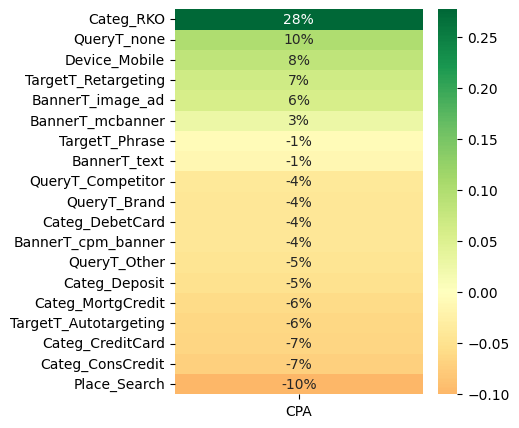

In [79]:
# Сначала проведем исследование с применением коэффициента Пирсона:

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize=(height, width)) 

sns.heatmap(df_sigma_view[colomns_review].corr().loc[:,['CPA']].drop('CPA').sort_values(by='CPA', ascending=False),\
            annot=True,\
            fmt=".0%",\
            cmap='RdYlGn',\
            center=0); 
plt.show()

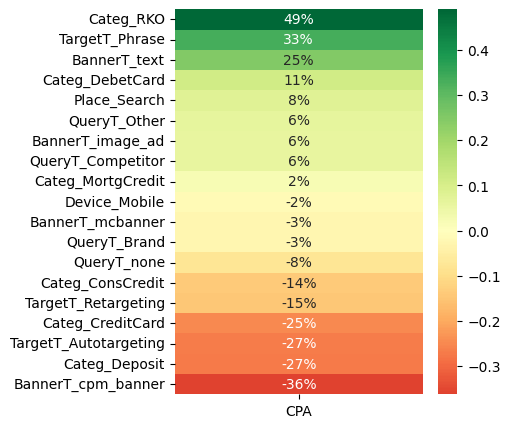

In [80]:
# Теперь проведем исследование с применением коэффициента Спирмена:
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize=(height, width)) 

sns.heatmap(df_sigma_view[colomns_review].corr(method='spearman').loc[:,['CPA']].drop('CPA').sort_values(by='CPA', ascending=False),\
            annot=True,\
            fmt=".0%",\
            cmap='RdYlGn',\
            center=0);
plt.show()

interval columns not set, guessing: ['Categ_Deposit', 'Categ_DebetCard', 'Categ_MortgCredit', 'Categ_CreditCard', 'Categ_ConsCredit', 'Categ_RKO', 'BannerT_cpm_banner', 'BannerT_image_ad', 'BannerT_mcbanner', 'BannerT_text', 'QueryT_Brand', 'QueryT_Competitor', 'QueryT_Other', 'QueryT_none', 'TargetT_Autotargeting', 'TargetT_Phrase', 'TargetT_Retargeting', 'Device_Mobile', 'Place_Search', 'CPA']


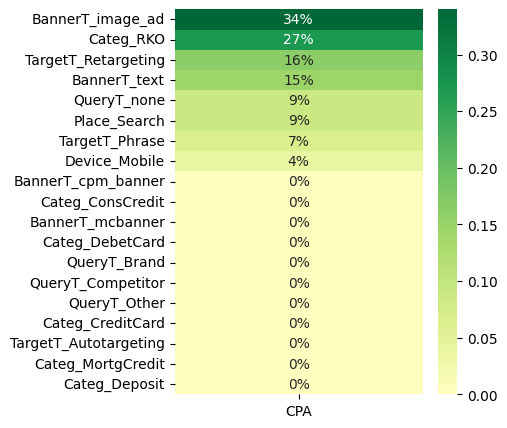

In [81]:
# Теперь проведем исследование с применением коэффициента Phi_K:
fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize=(height, width)) 

sns.heatmap(df_sigma_view[colomns_review].phik_matrix().loc[:,['CPA']].drop('CPA').sort_values(by='CPA', ascending=False),\
            annot=True,\
            fmt=".0%",\
            cmap='RdYlGn',\
            center=0); 
plt.show()

## Выводы, рекомендации

Исследуя коэффициенты корреляции:
- исследуя коэффициенты корреляции категории РКО с CPA (+28/+49/27) можно предположить, что удельная стоимость рекламы категории РКО выросла (возможно в следствии повышенной конкуренции за клиента в этой категории), т.е. если нужны целевые действия по данной категории - надо платить, если нужно сохранить бюджет - рекламировать другие категории

- так же для снижения и стабилизации CPA можно рекомендовать:
снизить ориентацию на:
  - QueryT_none(+10//9)
  - Device_Mobile(+8//4)

- более ориентироваться на:
  - Place_Search(-10//9)

- поэкспериментировать с:
  - TargetT_Phrase(0/+33/7)
  - BannerT_text(0/+25/15)
  - BannerT_image_ad(0/0/34)
  - TargetT_Retargeting(0/0/16)
  - Categ_Deposit(0/-27/0)
  - Categ_CreditCard(0/-25/0)
  - BannerT_cpm_banner(0/-36/0)
  - TargetT_Autotargeting(0/-27/0)

Так же, в т.ч. ввиду ухода с рынка основного конкурента Яндекса Google можно порекомендовать рассмотреть альтернативные площадки для рекламы